## Produce the json file listing all profiles in GS region

In [8]:
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from datetime import date
import io
import json


In [9]:
latmin,latmax,lonmin,lonmax=(32.6,65.6,-17,10)
datemin,datemax=('2010-01-01','2012-12-31')
jsonfile='EU_y2010-2011-2012.json'

In [3]:
!ls /scratch/cnt0024/hmg2840/albert7a/EN4/

20100101_prof.nc  20110110_prof.nc  20120119_prof.nc
20100102_prof.nc  20110111_prof.nc  20120120_prof.nc
20100103_prof.nc  20110112_prof.nc  20120121_prof.nc
20100104_prof.nc  20110113_prof.nc  20120122_prof.nc
20100105_prof.nc  20110114_prof.nc  20120123_prof.nc
20100106_prof.nc  20110115_prof.nc  20120124_prof.nc
20100107_prof.nc  20110116_prof.nc  20120125_prof.nc
20100108_prof.nc  20110117_prof.nc  20120126_prof.nc
20100109_prof.nc  20110118_prof.nc  20120127_prof.nc
20100110_prof.nc  20110119_prof.nc  20120128_prof.nc
20100111_prof.nc  20110120_prof.nc  20120129_prof.nc
20100112_prof.nc  20110121_prof.nc  20120130_prof.nc
20100113_prof.nc  20110122_prof.nc  20120131_prof.nc
20100114_prof.nc  20110123_prof.nc  20120201_prof.nc
20100115_prof.nc  20110124_prof.nc  20120202_prof.nc
20100116_prof.nc  20110125_prof.nc  20120203_prof.nc
20100117_prof.nc  20110126_prof.nc  20120204_prof.nc
20100118_prof.nc  20110127_prof.nc  20120205_prof.nc
20100119_prof.nc  20110128_prof.nc  20120206_p

In [9]:
def select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax,jsonfile):
        ''' Identify all the EN4 profiles that fall within the selected zone and period
        '''
        lday={1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
        lday_2012={1:31,2:29,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
        ## Datasets

        #EN4
        diren4="/scratch/cnt0024/hmg2840/albert7a/EN4/"

        yearmin=datemin[0:4]
        monthmin=datemin[5:7]
        yearmax=datemax[0:4]
        monthmax=datemax[5:7]

        list_filesEN4=[]
        if yearmin == yearmax:
            if yearmin == '2012':
                lday=lday_2012
            for m in np.arange(int(monthmin),int(monthmax)+1):
                mm = "{:02d}".format(m)
                for d in np.arange(1,lday[m]+1):
                    dd = "{:02d}".format(d)
                    list_filesEN4.append(yearmin+str(mm)+str(dd)+'_prof.nc')
        else:
            for m in np.arange(int(monthmin),13):
                mm = "{:02d}".format(m)
                for d in np.arange(1,lday[m]+1):
                    dd = "{:02d}".format(d)
                    list_filesEN4.append(yearmin+str(mm)+str(dd)+'_prof.nc')

        if int(yearmin)+1 == int(yearmax):
            if yearmax == '2012':
                lday=lday_2012
                for m in np.arange(1,int(monthmax)+1):
                    mm = "{:02d}".format(m)
                    for d in np.arange(1,lday[m]+1):
                        dd = "{:02d}".format(d)
                        list_filesEN4.append(yearmax+str(mm)+str(dd)+'_prof.nc')
        else:
            for year in np.arange(int(yearmin)+1,int(yearmax)+1):
                if year == 2012:
                    lday=lday_2012
                for m in np.arange(1,13):
                    mm = "{:02d}".format(m)
                    for d in np.arange(1,lday[m]+1):
                        dd = "{:02d}".format(d)
                        list_filesEN4.append(str(year)+str(mm)+str(dd)+'_prof.nc')

        datetmin=pd.to_datetime(datemin)
        datetmax=pd.to_datetime(datemax)
        ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
        ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
        tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
        tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()

        for f in np.arange(len(list_filesEN4)):
            fileEN4=list_filesEN4[f]
            print('Processing '+str(fileEN4))
            tfileEN4=diren4+fileEN4
            dsen4=xr.open_dataset(tfileEN4)
            laten4=dsen4['LATITUDE']
            lonen4=dsen4['LONGITUDE']
            dayen4=dsen4['JULD']
            refen4=dsen4['DC_REFERENCE']
            indz=np.where((lonmin<lonen4.values)&(lonen4.values<lonmax)&(latmin<laten4.values)&(laten4.values<latmax))
            prof_zone=[]
            tsecen4z=[]
            for ref in np.arange(len(indz[0])):
                dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
                ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
                tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
                if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                    prof_zone.append(indz[0][ref])
                    tsecen4z.append(tsecen4)

            for ref in np.arange(len(prof_zone)):
                if 'dictyml' in locals():
                    up={str(refen4[prof_zone[ref]].values):{'reference':str(refen4[prof_zone[ref]].values),'file':fileEN4,'profile no':int(prof_zone[ref]),'latitude':float(laten4[prof_zone[ref]].values),'longitude':float(lonen4[prof_zone[ref]].values),'date':str(dayen4[prof_zone[ref]].values)}}
                    dictyml.update(up)
                else:
                    dictyml={str(refen4[prof_zone[ref]].values):{'reference':str(refen4[prof_zone[ref]].values),'file':fileEN4,'profile no':int(prof_zone[ref]),'latitude':float(laten4[prof_zone[ref]].values),'longitude':float(lonen4[prof_zone[ref]].values),'date':str(dayen4[prof_zone[ref]].values)}}
                    
        with io.open(jsonfile, 'w', encoding='utf8') as outfile:
            outfile.write(str(json.dumps(dictyml, sort_keys=True,indent=4, separators=(',', ': '))))



In [10]:
select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax,jsonfile)

Processing 20100101_prof.nc
Processing 20100102_prof.nc
Processing 20100103_prof.nc
Processing 20100104_prof.nc
Processing 20100105_prof.nc
Processing 20100106_prof.nc
Processing 20100107_prof.nc
Processing 20100108_prof.nc
Processing 20100109_prof.nc
Processing 20100110_prof.nc
Processing 20100111_prof.nc
Processing 20100112_prof.nc
Processing 20100113_prof.nc
Processing 20100114_prof.nc
Processing 20100115_prof.nc
Processing 20100116_prof.nc
Processing 20100117_prof.nc
Processing 20100118_prof.nc
Processing 20100119_prof.nc
Processing 20100120_prof.nc
Processing 20100121_prof.nc
Processing 20100122_prof.nc
Processing 20100123_prof.nc
Processing 20100124_prof.nc
Processing 20100125_prof.nc
Processing 20100126_prof.nc
Processing 20100127_prof.nc
Processing 20100128_prof.nc
Processing 20100129_prof.nc
Processing 20100130_prof.nc
Processing 20100131_prof.nc
Processing 20100201_prof.nc
Processing 20100202_prof.nc
Processing 20100203_prof.nc
Processing 20100204_prof.nc
Processing 20100205_

Processing 20101022_prof.nc
Processing 20101023_prof.nc
Processing 20101024_prof.nc
Processing 20101025_prof.nc
Processing 20101026_prof.nc
Processing 20101027_prof.nc
Processing 20101028_prof.nc
Processing 20101029_prof.nc
Processing 20101030_prof.nc
Processing 20101031_prof.nc
Processing 20101101_prof.nc
Processing 20101102_prof.nc
Processing 20101103_prof.nc
Processing 20101104_prof.nc
Processing 20101105_prof.nc
Processing 20101106_prof.nc
Processing 20101107_prof.nc
Processing 20101108_prof.nc
Processing 20101109_prof.nc
Processing 20101110_prof.nc
Processing 20101111_prof.nc
Processing 20101112_prof.nc
Processing 20101113_prof.nc
Processing 20101114_prof.nc
Processing 20101115_prof.nc
Processing 20101116_prof.nc
Processing 20101117_prof.nc
Processing 20101118_prof.nc
Processing 20101119_prof.nc
Processing 20101120_prof.nc
Processing 20101121_prof.nc
Processing 20101122_prof.nc
Processing 20101123_prof.nc
Processing 20101124_prof.nc
Processing 20101125_prof.nc
Processing 20101126_

Processing 20110812_prof.nc
Processing 20110813_prof.nc
Processing 20110814_prof.nc
Processing 20110815_prof.nc
Processing 20110816_prof.nc
Processing 20110817_prof.nc
Processing 20110818_prof.nc
Processing 20110819_prof.nc
Processing 20110820_prof.nc
Processing 20110821_prof.nc
Processing 20110822_prof.nc
Processing 20110823_prof.nc
Processing 20110824_prof.nc
Processing 20110825_prof.nc
Processing 20110826_prof.nc
Processing 20110827_prof.nc
Processing 20110828_prof.nc
Processing 20110829_prof.nc
Processing 20110830_prof.nc
Processing 20110831_prof.nc
Processing 20110901_prof.nc
Processing 20110902_prof.nc
Processing 20110903_prof.nc
Processing 20110904_prof.nc
Processing 20110905_prof.nc
Processing 20110906_prof.nc
Processing 20110907_prof.nc
Processing 20110908_prof.nc
Processing 20110909_prof.nc
Processing 20110910_prof.nc
Processing 20110911_prof.nc
Processing 20110912_prof.nc
Processing 20110913_prof.nc
Processing 20110914_prof.nc
Processing 20110915_prof.nc
Processing 20110916_

Processing 20120603_prof.nc
Processing 20120604_prof.nc
Processing 20120605_prof.nc
Processing 20120606_prof.nc
Processing 20120607_prof.nc
Processing 20120608_prof.nc
Processing 20120609_prof.nc
Processing 20120610_prof.nc
Processing 20120611_prof.nc
Processing 20120612_prof.nc
Processing 20120613_prof.nc
Processing 20120614_prof.nc
Processing 20120615_prof.nc
Processing 20120616_prof.nc
Processing 20120617_prof.nc
Processing 20120618_prof.nc
Processing 20120619_prof.nc
Processing 20120620_prof.nc
Processing 20120621_prof.nc
Processing 20120622_prof.nc
Processing 20120623_prof.nc
Processing 20120624_prof.nc
Processing 20120625_prof.nc
Processing 20120626_prof.nc
Processing 20120627_prof.nc
Processing 20120628_prof.nc
Processing 20120629_prof.nc
Processing 20120630_prof.nc
Processing 20120701_prof.nc
Processing 20120702_prof.nc
Processing 20120703_prof.nc
Processing 20120704_prof.nc
Processing 20120705_prof.nc
Processing 20120706_prof.nc
Processing 20120707_prof.nc
Processing 20120708_

## Plot the locations of all profiles

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [11]:
    sourcefile=open(jsonfile,'rU',encoding='utf-8')
    infos=json.load(sourcefile)
    nb_profilesEN4=len(infos)
    list_profiles=infos.keys()

    all_lat=np.zeros((nb_profilesEN4))
    all_lon=np.zeros((nb_profilesEN4))
    
    for prof in np.arange(nb_profilesEN4):
        reference =  str(list(list_profiles)[prof])
        lat_prof = infos[reference]['latitude']
        lon_prof = infos[reference]['longitude']
        all_lat[prof]=lat_prof
        all_lon[prof]=lon_prof


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [12]:
len(all_lon)

4878

In [13]:
def map_profiles_from_jsonfile(all_lat,all_lon):
    


    fig=plt.figure(figsize=(10,15))
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
#    ax.set_extent((lonmin, lonmax, latmin, latmax))
#    ax.coastlines(resolution="10m")
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.scatter(all_lon, all_lat, c='g', linewidth='0', s=18);
    plt.title('EN4 profiles in GS region in 2010-2012', size=20);
    plt.savefig('profiles_EU_2010-2012.png')


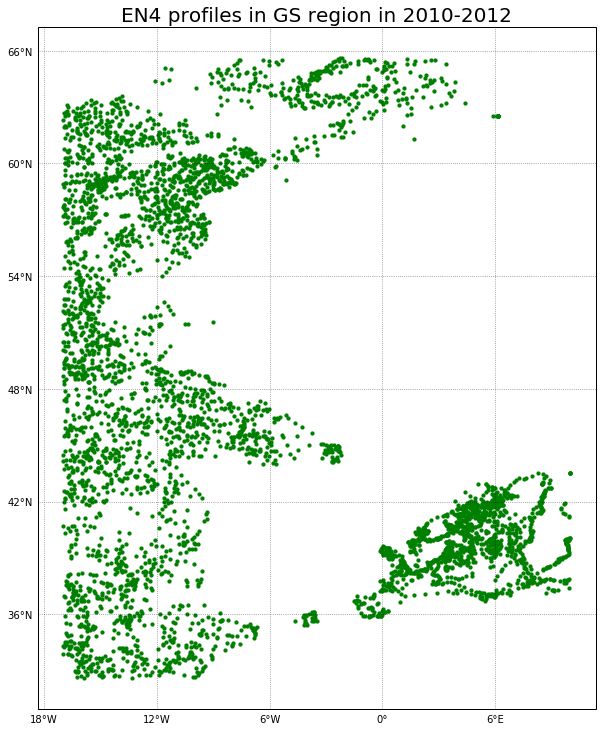

In [14]:
map_profiles_from_jsonfile(all_lat,all_lon)